In [1]:
!pip install git+https://github.com/Farama-Foundation/MAgent2

  Cloning https://github.com/Farama-Foundation/MAgent2 to /tmp/pip-req-build-9nzvjp24
  Running command git clone --filter=blob:none --quiet https://github.com/Farama-Foundation/MAgent2 /tmp/pip-req-build-9nzvjp24
  Resolved https://github.com/Farama-Foundation/MAgent2 to commit b2ddd49445368cf85d4d4e1edcddae2e28aa1406
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 86.4 MB/s eta 0:00:00:00:01:01
  Created wheel for magent2: filename=magent2-0.3.3-cp310-cp310-linux_x86_64.whl size=1657697 sha256=2d49b70ea359f669999bc7efba38050fadbfdbd2fc87ed902ee971c1b6d395a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-03ezbwh5/wheels/e4/8e/bf/51a30bc4038546e23b81c9fb513fe6a8fd916e5a9c5f4291d5
Successfully built magent2


## Import

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import os
from tqdm import tqdm

from magent2.environments import battle_v4
import cv2
from collections import deque
import time
import random
import warnings
warnings.filterwarnings('ignore')

## DQN

In [3]:
class QNetwork(nn.Module):
    def __init__(self, observation_shape, action_shape, device='cpu'):
        super().__init__()
        self.observation_shape = observation_shape
        self.action_shape = action_shape
        self.device = device

        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], observation_shape[-1], kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], kernel_size=3),
            nn.ReLU(),
        )

        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]
        self.network = nn.Sequential(
            nn.Linear(flatten_dim, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, action_shape),
        )

    def forward(self, x):
        assert len(x.shape) >= 3, "only support magent input observation"
        x = self.cnn(x)
        if len(x.shape) == 3:
            batchsize = 1
        else:
            batchsize = x.shape[0]
        x = x.reshape(batchsize, -1)
        return self.network(x)

## Replay Buffer

In [4]:
class ReplayMemory(Dataset):
    def __init__(self, maxlen):
        super().__init__()
        self.maxlen = maxlen
        self.step_memory = deque([],maxlen=self.maxlen)

    def push(self, observation, action, reward, next_observation, done):
        self.step_memory.append((observation, action, reward, next_observation, done))

    def __len__(self):
        return len(self.step_memory)

    def __getitem__(self, idx):
        observation, action, reward, next_observation, done = self.step_memory[idx]
        return (
            torch.Tensor(observation).float().permute([2, 0, 1]),
            torch.tensor(action),
            torch.tensor(reward, dtype=torch.float),
            torch.tensor(next_observation).float().permute([2,0,1]),
            torch.tensor(done, dtype=torch.float32),
        )
        

## Trainer

In [5]:
class Trainer:
    def __init__(
        self,
        env, replay_memory,
        policy_dqn, target_dqn,
        n_action,
        loss_fn, optimizer, scheduler,
        epsilon_start, epsilon_end, epsilon_decay,
        device='cpu'
    ):
        self.env = env
        self.replay_memory = replay_memory

        self.policy_dqn = policy_dqn.to(device)
        self.target_dqn = target_dqn.to(device)
        self.target_dqn.eval()

        self.n_action = n_action

        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler

        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.epsilon = self.epsilon_start

        self.device = device

        self.policy_dqn.apply(self.weights_init)

    def weights_init(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.xavier_uniform_(m.weight)
            if torch.is_tensor(m.bias):
                m.bias.data.fill_(0.01)


    def policy(self, observation):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.n_action)
        else:
            with torch.no_grad():
                q_values = self.policy_dqn(
                    torch.Tensor(observation).float().permute([2, 0, 1]).unsqueeze(0).to(self.device)
                )
            return torch.argmax(q_values, dim=1).cpu().numpy()[0]


    def optimize_model(self, batch_size, gamma):
        if len(replay_memory) < batch_size:
            return
        train_loader = DataLoader(self.replay_memory, batch_size=batch_size, shuffle=True)
        self.policy_dqn.train()

        for observations, actions, rewards, next_observations, dones in train_loader:

            self.policy_dqn.zero_grad()

            observations = observations.to(self.device)
            actions = actions.unsqueeze(1).to(self.device)
            rewards = rewards.unsqueeze(1).to(self.device)
            next_observations = next_observations.to(self.device)
            dones = dones.unsqueeze(1).to(self.device)

            current_q_values = self.policy_dqn(observations).gather(1, actions)

            with torch.no_grad():
                target_q_values = rewards + gamma * (1 - dones) * self.target_dqn(next_observations).max(1, keepdim=True)[0]

            # loss
            loss = self.loss_fn(current_q_values, target_q_values)

            loss.backward()
            self.optimizer.step()
            self.scheduler.step()

    def train(self,
                episodes,
              target_agent, batch_size, gamma,
              update_tg_freq, TAU
             ):
        train_rewards = []
        train_durations = []

        for episode in tqdm(range(episodes)):
            ep_reward = 0

            ep_steps = 0

            observations = {}
            actions = {}

            self.env.reset()

            for idx, agent in enumerate(self.env.agent_iter()):
                ep_steps += 1
                observation, reward, termination, truncation, info = self.env.last()

                if target_agent in agent:
                    ep_reward += reward
                else:
                    ep_reward -= reward

                action = self.policy(observation)
                
                observations[agent] = observation
                actions[agent] = action
                self.env.step(action)

                if (idx+1) % self.env.num_agents == 0:
                    break

            for agent in env.agent_iter():
                ep_steps += 1

                next_observation, reward, termination, truncation, info = self.env.last()

                if target_agent in agent:
                    ep_reward += reward
                else:
                    ep_reward -= reward

                # Agent die
                if termination or truncation:
                    action = None
                else:
                    action = self.policy(next_observation)

                self.replay_memory.push(
                    observations[agent],
                    actions[agent],
                    reward,
                    next_observation,
                    termination
                )

                observations[agent] = next_observation
                actions[agent] = action
                env.step(action)

            # Training
            self.optimize_model(batch_size, gamma)

            if episode % update_tg_freq == 0:
                target_dqn_state_dict = self.target_dqn.state_dict()
                policy_dqn_state_dict = self.policy_dqn.state_dict()
                for key in policy_dqn_state_dict:
                    target_dqn_state_dict[key] = policy_dqn_state_dict[key]*TAU + target_dqn_state_dict[key]*(1-TAU)
                self.target_dqn.load_state_dict(target_dqn_state_dict)


            self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

            print(f"\nEpisode {episode + 1}, Episode Reward: {ep_reward}, Steps: {ep_steps}, Epsilon: {self.epsilon}")

            train_rewards.append(ep_reward)
            train_durations.append(ep_steps)

        return train_rewards, train_durations

## Config

In [6]:

env = battle_v4.env(map_size=45, render_mode="rgb_array")

episodes = 40
target_agent = 'blue'
batch_size = 1024
gamma = 0.9
update_tg_freq = 1
TAU = 0.3

maxlen = 81 * episodes * 1000

learning_rate = 1e-3
theta = 1e-5
epsilon_start = 1
epsilon_end = 0.01
epsilon_decay = 0.9
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [7]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(42)

## Training Loop

In [8]:
policy_dqn = QNetwork(
    env.observation_space("red_0").shape, env.action_space("red_0").n
    )

target_dqn = QNetwork(
    env.observation_space("red_0").shape, env.action_space("red_0").n
    )

target_dqn.load_state_dict(policy_dqn.state_dict())

<All keys matched successfully>

In [9]:
loss_function = nn.MSELoss()

In [10]:
optimizer = torch.optim.AdamW(policy_dqn.parameters(), weight_decay=0, lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=episodes, eta_min=theta)

In [11]:
replay_memory = ReplayMemory(maxlen)

In [12]:

trainer = Trainer(
    env, replay_memory,
    policy_dqn, target_dqn,
    env.action_space("red_0").n,
    loss_function, optimizer, lr_scheduler,
    epsilon_start, epsilon_end, epsilon_decay,
    device=device
)

In [13]:

train_rewards, train_durations = trainer.train(
    episodes,
    target_agent, batch_size, gamma,
    update_tg_freq, TAU
)

  2%|▎         | 1/40 [00:20<13:00, 20.01s/it]


Episode 1, Episode Reward: 65.33500276319683, Steps: 158611, Epsilon: 0.9


  5%|▌         | 2/40 [01:09<23:32, 37.18s/it]


Episode 2, Episode Reward: -3.959999404847622, Steps: 160902, Epsilon: 0.81


  8%|▊         | 3/40 [02:17<31:37, 51.28s/it]


Episode 3, Episode Reward: -294.7350154807791, Steps: 106277, Epsilon: 0.7290000000000001


 10%|█         | 4/40 [03:42<38:44, 64.56s/it]


Episode 4, Episode Reward: 324.07001555524766, Steps: 79091, Epsilon: 0.6561000000000001


 12%|█▎        | 5/40 [05:26<45:57, 78.78s/it]


Episode 5, Episode Reward: 147.50000888016075, Steps: 72395, Epsilon: 0.5904900000000002


 15%|█▌        | 6/40 [07:39<55:06, 97.25s/it]


Episode 6, Episode Reward: -557.4300270192325, Steps: 93957, Epsilon: 0.5314410000000002


 18%|█▊        | 7/40 [10:17<1:04:28, 117.23s/it]


Episode 7, Episode Reward: 124.5100064445287, Steps: 81285, Epsilon: 0.47829690000000014


 20%|██        | 8/40 [13:01<1:10:26, 132.09s/it]


Episode 8, Episode Reward: -6.865000528283417, Steps: 40622, Epsilon: 0.43046721000000016


 22%|██▎       | 9/40 [16:17<1:18:29, 151.93s/it]


Episode 9, Episode Reward: -38.550000372342765, Steps: 70196, Epsilon: 0.38742048900000015


 25%|██▌       | 10/40 [19:25<1:21:36, 163.23s/it]


Episode 10, Episode Reward: 65.44499861635268, Steps: 11369, Epsilon: 0.34867844010000015


 28%|██▊       | 11/40 [22:59<1:26:21, 178.66s/it]


Episode 11, Episode Reward: 58.38499782048166, Steps: 43025, Epsilon: 0.31381059609000017


 30%|███       | 12/40 [26:42<1:29:42, 192.24s/it]


Episode 12, Episode Reward: -9.770000664517283, Steps: 36968, Epsilon: 0.28242953648100017


 32%|███▎      | 13/40 [30:34<1:31:57, 204.36s/it]


Episode 13, Episode Reward: 6.66500017978251, Steps: 27580, Epsilon: 0.25418658283290013


 35%|███▌      | 14/40 [34:45<1:34:36, 218.31s/it]


Episode 14, Episode Reward: 181.72000690549612, Steps: 37052, Epsilon: 0.22876792454961012


 38%|███▊      | 15/40 [39:29<1:39:12, 238.09s/it]


Episode 15, Episode Reward: 44.67000101972371, Steps: 63288, Epsilon: 0.2058911320946491


 40%|████      | 16/40 [44:11<1:40:34, 251.45s/it]


Episode 16, Episode Reward: -34.31500336434692, Steps: 23964, Epsilon: 0.1853020188851842


 42%|████▎     | 17/40 [48:59<1:40:31, 262.22s/it]


Episode 17, Episode Reward: -138.50499781873077, Steps: 15454, Epsilon: 0.16677181699666577


 45%|████▌     | 18/40 [53:49<1:39:15, 270.72s/it]


Episode 18, Episode Reward: 145.9999986551702, Steps: 9707, Epsilon: 0.1500946352969992


 48%|████▊     | 19/40 [58:55<1:38:26, 281.26s/it]


Episode 19, Episode Reward: 54.71500106342137, Steps: 25040, Epsilon: 0.13508517176729928


 50%|█████     | 20/40 [1:04:00<1:36:06, 288.35s/it]


Episode 20, Episode Reward: -80.0599992936477, Steps: 9187, Epsilon: 0.12157665459056936


 52%|█████▎    | 21/40 [1:09:14<1:33:45, 296.09s/it]


Episode 21, Episode Reward: 84.06999927945435, Steps: 12407, Epsilon: 0.10941898913151243


 55%|█████▌    | 22/40 [1:14:32<1:30:50, 302.83s/it]


Episode 22, Episode Reward: 234.9699983727187, Steps: 11608, Epsilon: 0.0984770902183612


 57%|█████▊    | 23/40 [1:20:08<1:28:35, 312.69s/it]


Episode 23, Episode Reward: -21.485000592656434, Steps: 23324, Epsilon: 0.08862938119652508


 60%|██████    | 24/40 [1:25:46<1:25:22, 320.17s/it]


Episode 24, Episode Reward: -122.34999916423112, Steps: 8008, Epsilon: 0.07976644307687257


 62%|██████▎   | 25/40 [1:31:27<1:21:36, 326.43s/it]


Episode 25, Episode Reward: -91.3999993223697, Steps: 7898, Epsilon: 0.07178979876918531


 65%|██████▌   | 26/40 [1:37:18<1:17:52, 333.78s/it]


Episode 26, Episode Reward: -184.459998967126, Steps: 8500, Epsilon: 0.06461081889226679


 68%|██████▊   | 27/40 [1:43:12<1:13:40, 340.04s/it]


Episode 27, Episode Reward: -86.1899995142594, Steps: 10757, Epsilon: 0.05814973700304011


 70%|███████   | 28/40 [1:49:10<1:09:05, 345.43s/it]


Episode 28, Episode Reward: 220.99499876610935, Steps: 7483, Epsilon: 0.0523347633027361


 72%|███████▎  | 29/40 [1:55:45<1:06:00, 360.06s/it]


Episode 29, Episode Reward: -19.28000004310161, Steps: 49126, Epsilon: 0.04710128697246249


 75%|███████▌  | 30/40 [2:02:36<1:02:34, 375.45s/it]


Episode 30, Episode Reward: 1.8399999449029565, Steps: 33810, Epsilon: 0.042391158275216244


 78%|███████▊  | 31/40 [2:09:20<57:37, 384.16s/it]  


Episode 31, Episode Reward: -122.22499974537641, Steps: 9151, Epsilon: 0.03815204244769462


 80%|████████  | 32/40 [2:16:16<52:29, 393.64s/it]


Episode 32, Episode Reward: 218.74999878648669, Steps: 14043, Epsilon: 0.03433683820292516


 82%|████████▎ | 33/40 [2:23:10<46:38, 399.81s/it]


Episode 33, Episode Reward: 261.20499836001545, Steps: 6971, Epsilon: 0.030903154382632643


 85%|████████▌ | 34/40 [2:30:09<40:32, 405.46s/it]


Episode 34, Episode Reward: -136.28499949350953, Steps: 6254, Epsilon: 0.02781283894436938


 88%|████████▊ | 35/40 [2:37:09<34:08, 409.70s/it]


Episode 35, Episode Reward: 145.2399989143014, Steps: 6343, Epsilon: 0.025031555049932444


 90%|█████████ | 36/40 [2:44:20<27:44, 416.07s/it]


Episode 36, Episode Reward: 50.385000058449805, Steps: 8174, Epsilon: 0.0225283995449392


 92%|█████████▎| 37/40 [2:51:52<21:21, 427.13s/it]


Episode 37, Episode Reward: -86.33999959565699, Steps: 8149, Epsilon: 0.020275559590445278


 95%|█████████▌| 38/40 [2:59:27<14:30, 435.42s/it]


Episode 38, Episode Reward: -190.1049988400191, Steps: 7078, Epsilon: 0.01824800363140075


 98%|█████████▊| 39/40 [3:07:23<07:27, 447.46s/it]


Episode 39, Episode Reward: 146.54999891575426, Steps: 6370, Epsilon: 0.016423203268260675


100%|██████████| 40/40 [3:15:06<00:00, 292.67s/it]


Episode 40, Episode Reward: 169.59499898087233, Steps: 5849, Epsilon: 0.014780882941434608


In [14]:
trainer.policy_dqn

QNetwork(
  (cnn): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (network): Sequential(
    (0): Linear(in_features=405, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=21, bias=True)
  )
)

In [15]:
torch.save(trainer.policy_dqn.state_dict(), 'blue.pt')

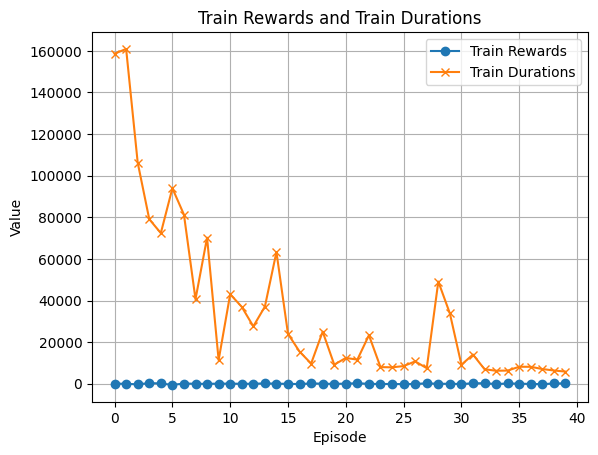

In [16]:
import matplotlib.pyplot as plt

plt.plot(train_durations, label='Train Durations', marker='x')
plt.title('Train Rewards and Train Durations')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.legend()  # Hiển thị chú thích
plt.grid(True)  # Hiển thị lưới
plt.show()